In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
liar_data = pd.read_csv('train (1).csv', names=["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pantson fire","context"])

In [3]:
liar_data['label'] = liar_data['label'].replace({
    'pants-fire': 0,
    'FALSE': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'TRUE': 1
})

In [4]:
# Select only the relevant columns for our task
liar_data = liar_data[['statement', 'label']]

In [6]:
# Split the data into training and testing sets
X = liar_data['statement']
y = liar_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Tokenize the statements using Keras' Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [8]:
# Convert the tokenized sequences to padded sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

In [9]:
# Build the RNN model
model = Sequential()
model.add(Embedding(5000, 64))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
116/116 [==============================] - 63s 351ms/step - loss: 0.6787 - accuracy: 0.5658 - val_loss: 0.6584 - val_accuracy: 0.5915
Epoch 2/50
116/116 [==============================] - 37s 321ms/step - loss: 0.6131 - accuracy: 0.6652 - val_loss: 0.6551 - val_accuracy: 0.6012
Epoch 3/50
116/116 [==============================] - 37s 317ms/step - loss: 0.5155 - accuracy: 0.7533 - val_loss: 0.7018 - val_accuracy: 0.6000
Epoch 4/50
116/116 [==============================] - 39s 341ms/step - loss: 0.4241 - accuracy: 0.8072 - val_loss: 0.8470 - val_accuracy: 0.6024
Epoch 5/50
116/116 [==============================] - 36s 312ms/step - loss: 0.3341 - accuracy: 0.8581 - val_loss: 0.9354 - val_accuracy: 0.5817


In [12]:
# Evaluate the model on the test set
score, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

32/32 [==============================] - 2s 70ms/step - loss: 0.9760 - accuracy: 0.5649
Test score: 0.9760158658027649
Test accuracy: 0.56494140625


In [24]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_binary = (y_pred_labels > 0.5).astype(int)

64/64 [==============================] - 2s 34ms/step


In [25]:
print(y_test.shape)
print(y_pred.shape)

(2048,)
(2048, 1)


In [26]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       888
           1       0.00      0.00      0.00      1160

    accuracy                           0.43      2048
   macro avg       0.22      0.50      0.30      2048
weighted avg       0.19      0.43      0.26      2048



C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[ 888    0]
 [1160    0]]


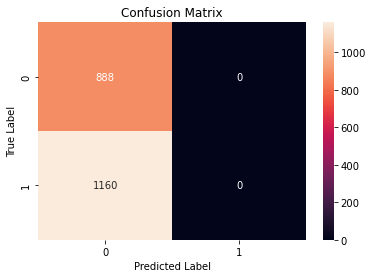

In [29]:
cm = confusion_matrix(y_test, y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AUC: 0.500


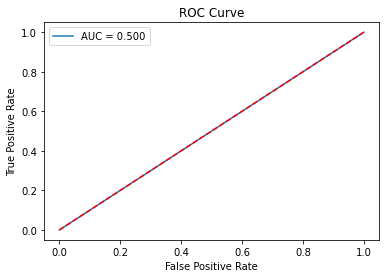

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)
print(f'AUC: {auc:.3f}')
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()